In [1]:
import sys
!{sys.executable} -m pip install chess

import os.path
import itertools
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure, transform
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2

import math
import chess

plt.gray();

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


<Figure size 432x288 with 0 Axes>

In [2]:
mpl.rcParams['figure.figsize'] = (10,10)

In [3]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


In [4]:
# FEN starts from rank 8 and ends at rank 1

WHITE_KING = 'K'
WHITE_QUEEN = 'Q'
WHITE_BISHOP = 'B'
WHITE_KNIGHT = 'N'
WHITE_ROOK = 'R'
WHITE_PAWN = 'P'

BLACK_KING = 'k'
BLACK_QUEEN = 'q'
BLACK_BISHOP = 'b'
BLACK_KNIGHT = 'n'
BLACK_ROOK = 'r'
BLACK_PAWN = 'p'

# A number in FEN represents number of empty spaces
RANK_DELIMITER = '/'

WHITES_TURN = 'w'
BLACKS_TURN = 'b'

WHITE_KINGSIDE_CASTLES = 'K'
WHITE_QUEENSIDE_CASTLES = 'Q'
BLACK_KINGSIDE_CASTLES = 'k'
BLACK_QUEENSIDE_CASTLES = 'q'
NO_CASTLES = '-'

# If there is an en passant then target square is recorded
NO_ENPASSANT = '-'

# The number of halfmoves since the last capture or pawn advance, used for the fifty-move rule
DEFAULT_HALF_MOVES = 0

# The number of the full move. It starts at 1, and is incremented after Black's move.
DEFAULT_HALF_MOVES = 1


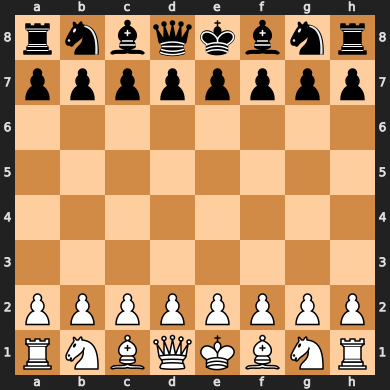

In [5]:
board = chess.Board()
board

In [6]:
"""
contours, _ = cv2.findContours((gray >= filters.threshold_otsu(gray)).view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours.squeeze()
contour = max(contours, key=cv2.contourArea)

out = cv2.drawContours(im.copy(), [contour], -1, (255, 0, 0), 2)
plt.imshow(out)
"""

"\ncontours, _ = cv2.findContours((gray >= filters.threshold_otsu(gray)).view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\ncontours = contours.squeeze()\ncontour = max(contours, key=cv2.contourArea)\n\nout = cv2.drawContours(im.copy(), [contour], -1, (255, 0, 0), 2)\nplt.imshow(out)\n"

In [7]:
def plot_lines_hough(im, angles, dists, intersection_points=[]):
    """
    Plots an image (im) and then draws the lines as given by the angles (in radians)
    and distances from (0,0).
    """
    h,w = im.shape

    # Plot the image and force the limits on the axes
    plt.imshow(im)
    plt.xlim((0, w))
    plt.ylim((h, 0))

    # Plot the lines
    xs = dists * np.cos(angles)
    ys = dists * np.sin(angles)
    for x, y, angle in zip(xs, ys, angles):
        plt.plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        plt.axline((x, y), slope=np.tan(angle + np.pi/2), color='red')

    for x, y in intersection_points:
        plt.plot(x, y, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12)


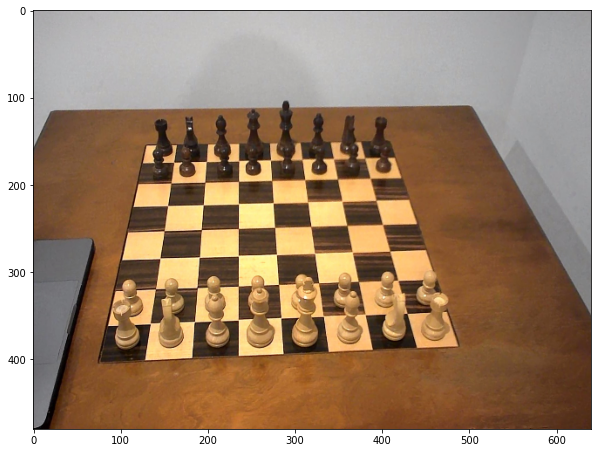

In [8]:
im = io.imread('chess_board_images/starting_chess_position_2.jpg')
im = cv2.resize(im, (640, 480))

plt.imshow(im)

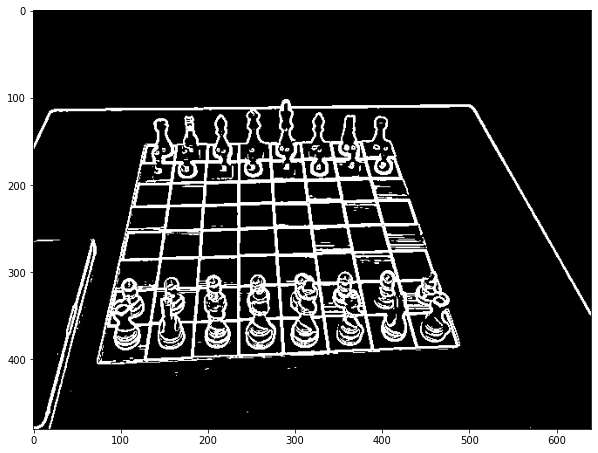

In [9]:
EDGE_DETECTION_THRESHOLD = 0.05
GAUSSIAN_BLUR = 0.75

gray = color.rgb2gray(im)
blurred = ndi.gaussian_filter(gray, GAUSSIAN_BLUR)
edges = filters.sobel(blurred)
thresh = edges > EDGE_DETECTION_THRESHOLD

plt.imshow(thresh)

In [10]:
'''
Debug single lines from hough lines.
'''
def plot_lines_hough_debug(im, angles, distances, line_index):
    pretty_distances = distances.round()
    pretty_angles = np.vectorize(math.degrees)(angles).round()

    print('distance: ' + str(pretty_distances[line_index]))
    print('angle: ' + str(pretty_angles[line_index]) + ' degrees')
    plot_lines_hough(im, angles[line_index:line_index+1], distances[line_index:line_index+1])


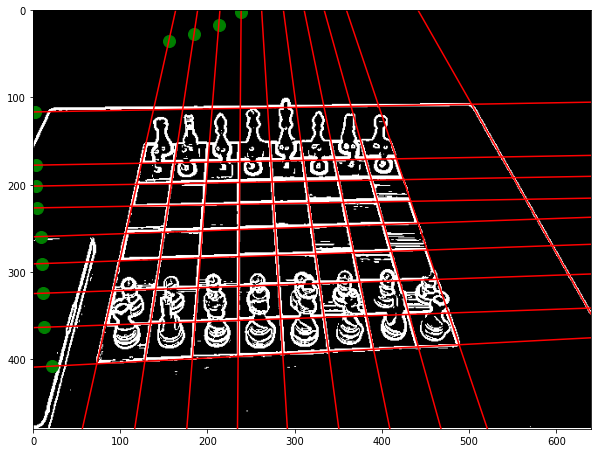

In [11]:
hough, angles, distances = transform.hough_line(thresh)
peak_vals, angles2, distances2 = transform.hough_line_peaks(hough, angles, distances)

plot_lines_hough(thresh, angles2, distances2)

In [12]:
'''
Splits lines into horizontal lines and vertical lines.
'''
def split_lines(angles, distances):
    assert len(angles) == len(distances)

    if len(angles) < 2:
        return [], [], [], []

    sorted_indices, angles = zip(*sorted(enumerate(angles), key=lambda x: x[1]))
    angle_diffs = [abs(angle - angles[(i+1) % len(angles)]) for i, angle in enumerate(angles)]

    copy = list(angle_diffs)
    max_index_1 = angle_diffs.index(max(copy))
    copy.pop(max_index_1)
    max_index_2 = angle_diffs.index(max(copy))

    assert max_index_1 != max_index_2

    if (max_index_2 < max_index_1):
        temp = max_index_1
        max_index_1 = max_index_2
        max_index_2 = temp

    h_angles =      angles[max_index_1+1:max_index_2+1]
    h_distances =   [distances[i] for i in sorted_indices[max_index_1+1:max_index_2+1]]

    v_angles =      angles[max_index_2+1:] + angles[:max_index_1+1]
    v_distances =   [distances[i] for i in sorted_indices[max_index_2+1:] + sorted_indices[:max_index_1+1]]

    return h_angles, h_distances, v_angles, v_distances


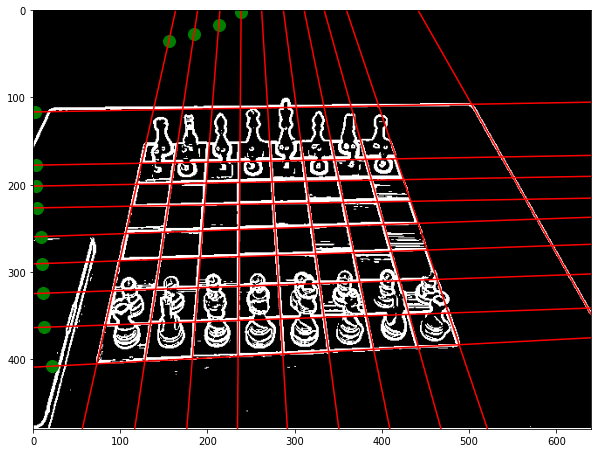

In [13]:
h_angles, h_distances, v_angles, v_distances = split_lines(angles2, distances2)
plot_lines_hough(thresh, h_angles, h_distances)
plot_lines_hough(thresh, v_angles, v_distances)

In [14]:
def convert_angle_dists_to_points_slopes(angles, dists):
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)
    
    points = [(x, y) for x, y in zip(x_coords, y_coords)]
    slopes = [np.tan(angle + (np.pi/2)) for angle in angles]

    return points, slopes

In [15]:
def find_y_intercept(point, slope):
    x, y = point
    return y - (slope*x)

In [16]:
def find_intersections(h_angles, h_distances, v_angles, v_distances):
    assert len(h_angles) == len(h_distances)
    assert len(v_angles) == len(v_distances)

    h_points, h_slopes = convert_angle_dists_to_points_slopes(h_angles, h_distances)
    v_points, v_slopes = convert_angle_dists_to_points_slopes(v_angles, v_distances)

    h_intercepts = [find_y_intercept(p, s) for p, s in zip(h_points, h_slopes)]
    v_intercepts = [find_y_intercept(p, s) for p, s in zip(v_points, v_slopes)]

    intersections = []

    for b1, m1 in zip(h_intercepts, h_slopes):
        for b2, m2 in zip(v_intercepts, v_slopes):
            x = (b2 - b1) / (m1 - m2)
            y = (m1 * x) + b1
            intersections.append((x, y))

    return intersections

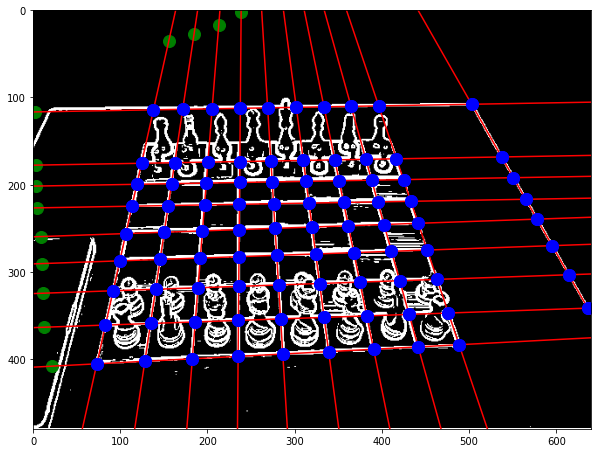

In [17]:
intersections = find_intersections(h_angles, h_distances, v_angles, v_distances)
plot_lines_hough(thresh, h_angles, h_distances, intersections)
plot_lines_hough(thresh, v_angles, v_distances, intersections)

In [18]:
from ImageProcessingF2021.video import run_video

In [19]:
def find_chess_board(im):
    EDGE_DETECTION_THRESHOLD = 0.05

    gray = color.rgb2gray(im)
    blurred = ndi.gaussian_filter(gray, 0.5)
    edges = filters.sobel(blurred)
    thresh = edges > EDGE_DETECTION_THRESHOLD

    hough, angles, distances = transform.hough_line(thresh)
    peak_vals, angles, distances = transform.hough_line_peaks(hough, angles, distances)

    # h_angles, h_distances, v_angles, v_distances = split_lines(angles, distances)
    
    return thresh

# run_video(find_chess_board, camera_num=0)